In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/NYU_v2
import h5py
import os
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import multiprocessing
import matplotlib.pyplot as plt
from torchvision import transforms
import time
import csv 
from scipy.spatial.distance import cdist
from torch.optim import lr_scheduler
import random
#from model import D3
torch.set_default_tensor_type('torch.FloatTensor')

/content/drive/MyDrive/Colab Notebooks/NYU_v2


In [ ]:
cuda  = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

In [ ]:
""" Mask and Sparse Downsampling function """
def generate_mask(fh, fw, H, W):
  mask = np.zeros((H,W),dtype = np.bool)
  mask[0:None:fh, 0:None:fw] = 1
  return mask


def NN_fill(img, depth, mask):
 
  H, W, _ = img.shape
  
  dist_arr = np.array(np.where(depth>0)).transpose()
  e = np.where(mask)                                                     # identify the index of true elements of mask 
  g = np.where(depth[e[0],e[1]]==0)                                       # identify coresponding elements in depth for which the values are zero      
  g = (np.array(e).transpose())[g[0]]                                 # identify the index of elements which are refered my mask matrix and its value is zero in image
  h = np.array([np.argmin(np.linalg.norm(dist_tuple - c,axis = 1)) for c in g],dtype='int32')     #identify nearest element in image whose value is not zero. 
  h = dist_arr[h]                                                    # identify the index of nearest element
  mask[g[:,0],g[:,1]]=0                                                  #replace the matrix value at zero with false
  mask[h[:,0],h[:,1]]=1                                                  #replae the nearest non negative element's index value with true in mask 
  

 
  sparse_data = np.array(np.where(mask)).transpose()
  idx_to_depth = {}
  for i,(x,y) in enumerate(sparse_data):      # converting the mask points into 1-D vector
    idx_to_depth[i] = x * W + y 

  S1 = np.zeros((H, W), dtype = np.float32)
  S2 = np.zeros((H, W), dtype = np.float32)
  for i in np.arange(0,480,60):                                  # divide the image into 3 parts adn perform array operation on three parts and put the image together.
    for j in  np.arange(0,640,80):
      points = np.array([[k,l] for k in np.arange(i,i+60) for l in np.arange(j,j+80)])
      dist = cdist(sparse_data,points)
      dmap =  np.argmin(dist,0)
      dmap_arg = ([idx_to_depth[k] for k in dmap])
      S1[i:i+60,j:j+80] = np.array(depth).ravel()[dmap_arg].reshape(60, 80)
      S2[i:i+60,j:j+80] = np.sqrt(np.min(dist,0)).reshape(60, 80)
  S1=S1[None]  
  S2=S2[None]    
  return np.concatenate((S1, S2))



In [ ]:
""" Initializing Dataset class"""
class NYU_V2 (Dataset):
  def __init__(self, trn_tst = 0, transform = None, flip = None):
    data = h5py.File('nyu_depth_v2_labeled.mat')

    if trn_tst == 0:
      #trainloader
      self.images = torch.from_numpy(data["images"][0:100].transpose(0,1,3,2))
      self.depths = torch.from_numpy(data["depths"][0:100].transpose(0,2,1))
    
    if trn_tst == 1:
      #testloader
      self.images = torch.from_numpy(data["images"][1400:1449].transpose(0,1,3,2))
      self.depths = torch.from_numpy(data["depths"][1400:1449].transpose(0,2,1))

    if trn_tst == 2:
      #trainloader
      self.images = torch.from_numpy(data["images"][1300:1325].transpose(0,1,3,2))
      self.depths = torch.from_numpy(data["depths"][1300:1325].transpose(0,2,1))
      
    self.flip = flip
    self.transform = transform
    self.transform_images = transforms.Compose([transforms.Normalize((0, 0, 0),(255, 255, 255))])
    self.transform_depth = transforms.Normalize((0),(10))
    if self.flip:
      num_img = self.images.shape[0]
      j = 0
      for i in np.linspace(0,num_img,50).astype(int)[1:]:
        temp_img = torchvision.transforms.functional.hflip(self.images[j:i,:,:,:])
        self.images = torch.cat((self.images,temp_img),0)
        temp_img = 0  # just for reducing memory
        temp_depths = torchvision.transforms.functional.hflip(self.depths[j:i,:,:])
        self.depths = torch.cat((self.depths,temp_depths),0)
        temp_depths = 0 # just for reducing memory
        j = i
    
  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    sample = self.images[idx,:]
    s_depth = self.depths[idx,:]
    if self.transform:
      
      s_depth = torch.unsqueeze(s_depth,0)
      sample = self.transform_images(sample.float())
      sample = torch.from_numpy(np.transpose(sample.numpy(),(1,2,0)))
      s_depth = self.transform_depth(s_depth)
      s_depth = torch.squeeze(s_depth,0)
    else:
      sample = torch.from_numpy(np.transpose(sample.numpy(),(1, 2, 0)))
      #s_depth = torch.from_numpy(np.transpose(s_depth.numpy(),(1, 0)))
    
    return sample, s_depth
            

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  after removing the cwd from sys.path.


Number of training examples: 2600
Number of test examples: 200


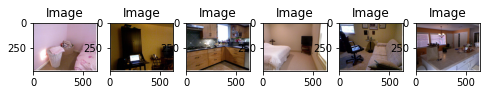

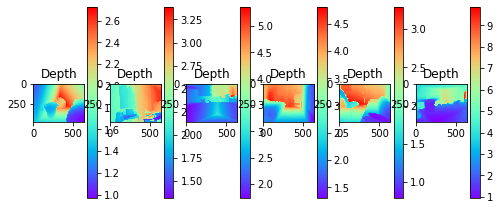

In [ ]:
# 24x24 downsampling
torch.backends.cudnn.deterministic = True
random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)

""" Creating Train Loaders """
train_set = NYU_V2(trn_tst = 0, transform = False, flip = True)
#test_set = NYU_V2(trn_tst = 1, transform = True, flip = True)
val_set = NYU_V2(trn_tst = 2, transform = False, flip = True)

print(f'Number of training examples: {train_set.__len__()}')
print(f'Number of test examples: {val_set.__len__()}')

#val_data, train_data = torch.utils.data.random_split(train_set, [int(np.round(len(train_set)*0.2)), int(np.round(len(train_set)*0.8))])

batch_size = 6
n_workers = multiprocessing.cpu_count()
#mask = generate_mask(24, 24, 480, 640)
#initialising data loaders
trainloader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = n_workers)
#testloader = torch.utils.data.DataLoader(test_set, batch_size = batch_size, shuffle = True, num_workers = n_workers)
valloader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = n_workers)
img_batch, depth_batch = next(iter(trainloader)) 

"""Plot dataset """
plt.figure(figsize = (8,8))

for tmp in range(batch_size):
  plt.subplot(1,batch_size,tmp+1)
  plt.imshow((img_batch[tmp]))    # an image with RGB values (0-1 float or 0-255 int)(the vale from class is in the range of [-1 to 1],
                                        # multiplying and adding 0.5 converts it to range [0 - 1.0])
  plt.title("Image")
plt.show()

plt.figure(figsize = (8,8))
for tmp in range(batch_size):
  plt.subplot(1,batch_size,tmp+1)
  plt.imshow(depth_batch[tmp],interpolation='none', cmap = 'rainbow')  # for single channel images plt.imshow normalizes the values so we dont need the (x(*0.5)+0.5)
  plt.colorbar()
  plt.title("Depth")


In [ ]:
""" D3 and Densenet Models """
class denseNet(nn.Module):
  '''
  https://arxiv.org/pdf/1608.06993.pdf
  '''
  def __init__(self, in_c, L = 5, K = 12):
    '''
    denseNet block
    
    Params:
      in_c : no. of input chanels
      L : no. of denseNet layers
      K : no. of output chanels
    '''
    super(denseNet, self).__init__()
    self.l = L
    self.k = K

    self.L1_conv1 = nn.Conv2d(in_c+2, self.k*4, kernel_size = 1, stride = 1)
    self.bn1 = nn.BatchNorm2d(self.k*4)
    self.L1_conv2 = nn.Conv2d(self.k*4, self.k, kernel_size = 3, stride = 1, padding = 1)
    self.bn2 = nn.BatchNorm2d(self.k)

    self.L2_conv1 = nn.Conv2d(self.k+2+in_c, self.k*4, kernel_size = 1, stride = 1)
    self.bn3 = nn.BatchNorm2d(self.k*4)
    self.L2_conv2 = nn.Conv2d(self.k*4, self.k, kernel_size = 3, stride = 1, padding = 1)
    self.bn4 = nn.BatchNorm2d(self.k)

    self.L3_conv1 = nn.Conv2d(self.k*2+2+in_c, self.k*4, kernel_size = 1, stride = 1)
    self.bn5 = nn.BatchNorm2d(self.k*4)
    self.L3_conv2 = nn.Conv2d(self.k*4, self.k, kernel_size = 3, stride = 1, padding = 1)
    self.bn6 = nn.BatchNorm2d(self.k)

    self.L4_conv1 = nn.Conv2d(self.k*3+2+in_c, self.k*4, kernel_size = 1, stride = 1)
    self.bn7 = nn.BatchNorm2d(self.k*4)
    self.L4_conv2 = nn.Conv2d(self.k*4, self.k, kernel_size = 3, stride = 1, padding = 1)
    self.bn8 = nn.BatchNorm2d(self.k)

    self.L5_conv1 = nn.Conv2d(self.k*4+2+in_c, self.k*4, kernel_size = 1, stride = 1)
    self.bn9 = nn.BatchNorm2d(self.k*4)
    self.L5_conv2 = nn.Conv2d(self.k*4, self.k, kernel_size = 3, stride = 1, padding = 1)
    self.bn10 = nn.BatchNorm2d(self.k)

  def forward(self, x, sp_inputs):

    sp_inputs = torch.tensor(sp_inputs).float()

    x1 = torch.cat((x, sp_inputs), 1)   # we process in batches 1st dim is element in batch and second element represent the channel
    x1 = torch.relu(self.bn1(self.L1_conv1(x1)))
    x1 = torch.relu(self.bn2(self.L1_conv2(x1)))
    
    x2 = torch.cat((x, x1, sp_inputs), 1)
    x2 = torch.relu(self.bn3(self.L2_conv1(x2)))
    x2 = torch.relu(self.bn4(self.L2_conv2(x2)))
    
    x3 = torch.cat((x, x1, x2, sp_inputs), 1)
    x3 = torch.relu(self.bn5(self.L3_conv1(x3)))
    x3 = torch.relu(self.bn6(self.L3_conv2(x3)))
    
    x4 = torch.cat((x, x1, x2, x3, sp_inputs), 1)
    x4 = torch.relu(self.bn7(self.L4_conv1(x4)))
    x4 = torch.relu(self.bn8(self.L4_conv2(x4)))
    
    x5 = torch.cat((x, x1, x2, x3, x4, sp_inputs), 1)
    x5 = torch.relu(self.bn9(self.L5_conv1(x5)))
    x5 = torch.relu(self.bn10(self.L5_conv2(x5)))
    
    return x5

class D3(nn.Module):

  def __init__(self):


    super(D3, self).__init__()

    # First Convolution layer
    self.conv1 = nn.Conv2d(5, 64, kernel_size = 3, stride = 2, padding = 1)

    # Downsampling denseNet block 1
    self.dense1_conv1 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
    self.dense1_bn1 = nn.BatchNorm2d(64)
    self.densenet1 = denseNet(64)
    self.dense1_conv2 = nn.Conv2d(12, 64, kernel_size = 3, stride = 2, padding = 1)
    self.dense1_bn2 = nn.BatchNorm2d(64)

    # Downsampling denseNet block 2
    self.dense2_conv1 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
    self.dense2_bn1 = nn.BatchNorm2d(64)
    self.densenet2 = denseNet(64)
    self.dense2_conv2 = nn.Conv2d(12, 64, kernel_size = 3, stride = 2, padding = 1)
    self.dense2_bn2 = nn.BatchNorm2d(64)

    # Skip dense2 block
    self.skip_d2_conv1 = nn.Conv2d(64, 64, kernel_size=3, stride = 1, padding = 1)    
    self.skip_d2_bn1 = nn.BatchNorm2d(64)
    self.skip_densenet2 = denseNet(64)
    self.skip_d2_conv2 = nn.Conv2d(12, 64, kernel_size=3, stride = 1, padding = 1)
    self.skip_d2_bn2 = nn.BatchNorm2d(64)

    # Downsampling denseNet block 3 
    self.dense3_conv1 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
    self.dense3_bn1 = nn.BatchNorm2d(64)
    self.densenet3 = denseNet(64)
    self.dense3_conv2 = nn.Conv2d(12, 64, kernel_size = 3, stride = 2, padding = 1)
    self.dense3_bn2 = nn.BatchNorm2d(64)

    # Skip dense3 block
    self.skip_d3_conv1 = nn.Conv2d(64, 64, kernel_size=3, stride = 1, padding = 1)    
    self.skip_d3_bn1 = nn.BatchNorm2d(64)
    self.skip_densenet3 = denseNet(64)
    self.skip_d3_conv2 = nn.Conv2d(12, 64, kernel_size=3, stride = 1, padding = 1)
    self.skip_d3_bn2 = nn.BatchNorm2d(64)

    # Downsampling denseNet block 4 
    self.dense4_conv1 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
    self.dense4_bn1 = nn.BatchNorm2d(64)
    self.densenet4 = denseNet(64)
    self.dense4_conv2 = nn.Conv2d(12, 64, kernel_size = 3, stride = 2, padding = 1)
    self.dense4_bn2 = nn.BatchNorm2d(64)

    # Skip dense4 block
    self.skip_d4_conv1 = nn.Conv2d(64, 64, kernel_size=3, stride = 1, padding = 1)    
    self.skip_d4_bn1 = nn.BatchNorm2d(64)
    self.skip_densenet4 = denseNet(64)
    self.skip_d4_conv2 = nn.Conv2d(12, 64, kernel_size=3, stride = 1, padding = 1)
    self.skip_d4_bn2 = nn.BatchNorm2d(64)

    # Downsampling denseNet block 5
    self.dense5_conv1 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
    self.dense5_bn1 = nn.BatchNorm2d(64)
    self.densenet5 = denseNet(64)
    self.dense5_conv2 = nn.Conv2d(12, 64, kernel_size = 3, stride = 1, padding = 1)
    self.dense5_bn2 = nn.BatchNorm2d(64)

    # Downsampling densnet block 6
    self.dense6_conv1 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
    self.dense6_bn1 = nn.BatchNorm2d(64)
    self.densenet6 = denseNet(64)
    self.dense6_conv2 = nn.Conv2d(12, 64, kernel_size = 3, stride = 1, padding = 1)
    self.dense6_bn2 = nn.BatchNorm2d(64)

    # Upsampling denseNet block 1
    self.up_dense1_conv1 = nn.ConvTranspose2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
    self.up_dense1_bn1 = nn.BatchNorm2d(64)
    self.up_densenet1 = denseNet(64)
    self.up_dense1_conv2 = nn.ConvTranspose2d(12, 64, kernel_size = 2, stride = 2, padding = 0)
    self.up_dense1_bn2 = nn.BatchNorm2d(64)

    # Upsampling denseNet block 2
    self.up_dense2_conv1 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
    self.up_dense2_bn1 = nn.BatchNorm2d(64)
    self.up_densenet2 = denseNet(64)
    self.up_dense2_conv2 = nn.ConvTranspose2d(12, 64, kernel_size = 2, stride = 2, padding = 0)
    self.up_dense2_bn2 = nn.BatchNorm2d(64)

    # Upsampling denseNet block 3
    self.up_dense3_conv1 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
    self.up_dense3_bn1 = nn.BatchNorm2d(64)
    self.up_densenet3 = denseNet(64)
    self.up_dense3_conv2 = nn.ConvTranspose2d(12, 64, kernel_size = 2, stride = 2, padding = 0)
    self.up_dense3_bn2 = nn.BatchNorm2d(64)

    # Upsampling densNet block 4
    self.up_dense4_conv1 = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding = 1)
    self.up_dense4_bn1 = nn.BatchNorm2d(64)
    self.up_densenet4 = denseNet(64)
    self.up_dense4_conv2 = nn.ConvTranspose2d(12, 64, kernel_size = 2, stride = 2, padding = 0)
    self.up_dense4_bn2 = nn.BatchNorm2d(64)

    # Transpose convolution
    self.up_conv1 = nn.ConvTranspose2d(64, 1, kernel_size = 2, stride = 2, padding = 0)

  def forward(self, x, sp_inputs):
    sp_inputs= sp_inputs.float()

    # conv1
    x = torch.cat((x, sp_inputs), 1)
    x = torch.relu(self.conv1(x))

    # densenet1 # h scales down the size of the image to match with the output of previous dense/convolution block
    h = nn.functional.interpolate(sp_inputs, scale_factor = 0.5, mode = "bilinear", align_corners = True)
    x = torch.relu(self.dense1_bn1(self.dense1_conv1(x)))
    x = self.densenet1(x,h)
    x = torch.relu(self.dense1_bn2(self.dense1_conv2(x)))
    
    # skip densenet2
    h2 = nn.functional.interpolate(h, scale_factor = 0.5, mode = "bilinear", align_corners = True)
    skip_x2 = torch.relu(self.skip_d2_bn1(self.skip_d2_conv1(x)))
    skip_x2 = self.skip_densenet2(skip_x2, h2)
    skip_x2 = torch.relu(self.skip_d2_bn2(self.skip_d2_conv2(skip_x2)))
    
    # densenet 2
    x = torch.relu(self.dense2_bn1(self.dense2_conv1(x)))
    x = self.densenet2(x, h2)
    x = torch.relu(self.dense2_bn2(self.dense2_conv2(x)))
    
    # skip densenet3
    h3 = nn.functional.interpolate(h2, scale_factor = 0.5, mode = "bilinear", align_corners = True)
    skip_x3 = torch.relu(self.skip_d3_bn1(self.skip_d3_conv1(x)))
    skip_x3 = self.skip_densenet3(skip_x3, h3)
    skip_x3 = torch.relu(self.skip_d3_bn2(self.skip_d3_conv2(skip_x3))) 
    
    # densenet 3 
    x = torch.relu(self.dense3_bn1(self.dense3_conv1(x)))
    x = self.densenet3(x, h3)
    x = torch.relu(self.dense3_bn2(self.dense3_conv2(x)))
    
    # skip densenet4
    h4 = nn.functional.interpolate(h3, scale_factor = 0.5, mode = "bilinear", align_corners = True)
    skip_x4 = torch.relu(self.skip_d4_bn1(self.skip_d4_conv1(x)))
    skip_x4 = self.skip_densenet4(skip_x4, h4)
    skip_x4 = torch.relu(self.skip_d4_bn2(self.skip_d4_conv2(skip_x4)))
    
    # densenet 4 
    x = torch.relu(self.dense4_bn1(self.dense4_conv1(x)))
    x = self.densenet4(x, h4)
    x = torch.relu(self.dense4_bn2(self.dense4_conv2(x)))
    
    # densenet 5
    h5 = nn.functional.interpolate(h4, scale_factor = 0.5, mode="bilinear", align_corners=True)
    x = torch.relu(self.dense5_bn1(self.dense5_conv1(x)))
    x = self.densenet5(x, h5)
    x = torch.relu(self.dense5_bn2(self.dense5_conv2(x)))
       
    # densenet6
    x = torch.relu(self.dense6_bn1(self.dense6_conv1(x)))
    x = self.densenet6(x, h5)
    x = torch.relu(self.dense6_bn2(self.dense6_conv2(x)))
    
    # up dense block 1
    x = torch.relu(self.up_dense1_bn1(self.up_dense1_conv1(x)))
    x = self.up_densenet1(x, h5)
    x = torch.relu(self.up_dense1_bn2(self.up_dense1_conv2(x)))
    
    x = x + skip_x4

    #up dense block 2
    x = torch.relu(self.up_dense2_bn1(self.up_dense2_conv1(x)))
    x = self.up_densenet2(x, h4)
    x = torch.relu(self.up_dense2_bn2(self.up_dense2_conv2(x)))
    
    x = x + skip_x3

    # up dense block 3
    x = torch.relu(self.up_dense3_bn1(self.up_dense3_conv1(x)))
    x = self.up_densenet3(x, h3)
    x = torch.relu(self.up_dense3_bn2(self.up_dense3_conv2(x)))
    
    x = x + skip_x2
    
    # up dense block 4
    x = torch.relu(self.up_dense4_bn1(self.up_dense4_conv1(x)))
    x = self.up_densenet4(x, h2)
    x = torch.relu(self.up_dense4_bn2(self.up_dense4_conv2(x)))
    
    x = self.up_conv1(x)
    
    return x 

                                


In [ ]:
"""model = D3()
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters: ", pytorch_total_params, "\nTotal number of trainable parameters: ",pytorch_total_params_trainable)"""

Total number of parameters:  1191381 
Total number of trainable parameters:  1191381


In [ ]:
def loss_calc(fx, y):
  L2_loss = nn.MSELoss(reduction='sum')
  MSE_loss = nn.MSELoss()

  L2 = L2_loss(fx, y)
  MSE = MSE_loss(fx, y)
  RMSE_loss = torch.sqrt(MSE)

  return L2, RMSE_loss

In [ ]:
""" Validation """
def validation(net, device, loader, mask_sample):
    
  with torch.no_grad():
    net.eval()
    net.to(device)
    running_loss_L2 = 0.0
    RMSE_running_loss = 0.0
    loss_L2 = []
    RMSE_loss = []          
    
    #concat x with spatial data
    for i, (x, y) in enumerate(loader):
      NN = []
      mask = generate_mask(mask_sample, mask_sample, 480, 640)
          
      # concat x with spatial data
      for j in range(x.shape[0]):
        sp = NN_fill(x[j].numpy(), y[j].numpy(), mask)
        NN.append(sp)
      NN = torch.tensor(NN)
      NN = NN.float()

      x = (x.permute(0, 3, 1, 2))/255.
      x = x.to(device) 
      y = y.to(device)
      NN = NN.to(device)
      fx = net(x, NN)
      fx = fx.permute(1, 0, 2, 3)
      NN = NN.permute(1, 0, 2, 3)
      fx = NN[0]+fx[0]
      
      loss_L2, RMSE_loss = loss_calc(fx, y)
      
      running_loss_L2 += loss_L2.item()
      RMSE_running_loss += RMSE_loss.item()
    
  running_loss_L2 /= len(loader)
  RMSE_running_loss /= len(loader)
  print('sparse data sampling', mask_sample, ' x ',mask_sample)
  print('Validation Loss (L2): ', running_loss_L2, 'Validation Loss (RMSE): ', RMSE_running_loss)
    
  return running_loss_L2, RMSE_running_loss

In [ ]:
"""Training function (per epoch)"""

def train(net, device, loader, optimizer, loss_fun, epoch, exp):

  # initialise counters
  running_loss = 0.0
  RMSE_running_loss = 0.0
  loss = []
  RMSE_loss = []
  net.train()
  #torch.no_grad()
  Train_step = epoch*len(loader)
  no_sparse = (5 * 533 * np.exp(-exp*Train_step))+533     # -0.24 because sparse sampling size/no. of training batches 24/100 in tis case
  mask_sample = int(np.sqrt(1/(no_sparse/(480*640))))
  # train batch
  start_time = time.time()
  for i, (x, y) in enumerate(loader):
    NN = []
    mask = generate_mask(mask_sample, mask_sample, 480, 640)
    Train_step = Train_step+1
    no_sparse = (5 * 533 * np.exp(-exp*Train_step))+533
    mask_sample = int(np.sqrt(1/(no_sparse/(480*640))))
    
    # concat x with spatial data
    for j in range(x.shape[0]):
      sp = NN_fill(x[j].numpy(), y[j].numpy(), mask)
      NN.append(sp)
    NN = torch.tensor(NN)
    NN = NN.float()

    optimizer.zero_grad()

    x = (x.permute(0, 3, 1, 2))/255.
    x = x.to(device) 
    y = y.to(device)
    NN = NN.to(device)
    fx = net(x, NN)
    fx = fx.permute(1, 0, 2, 3)
    NN = NN.permute(1, 0, 2, 3)
    fx = NN[0]+fx[0]
    
    loss, RMSE_loss = loss_calc(fx, y)
    
    running_loss += loss.item()
    RMSE_running_loss += RMSE_loss.item()
    
    loss.backward()
    optimizer.step()

  #end training 
  end_time = time.time() 
  running_loss /= len(loader)
  RMSE_running_loss /= len(loader)
  print('sparse data sampling', mask_sample, ' x ',mask_sample)
  print('Training Loss (L2): ', running_loss, 'Training Loss (RMSE): ', RMSE_running_loss,'Time: ',end_time - start_time, 's')

  torch.save(net.state_dict(), "./Model_D3_1_0_200.pt") 
  
  return running_loss, RMSE_running_loss, mask_sample



In [ ]:
mask = generate_mask(24,24,480,640)
a = NN_fill(img_batch[0],depth_batch[0],mask)

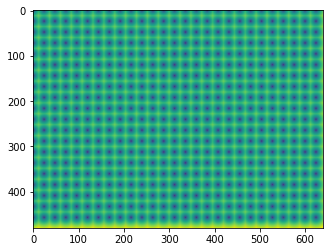

In [ ]:
plt.imshow(a[1])

In [ ]:
""" Training loop (for multiple epochs)"""

CSV_FIELDNAMES = ["Epoch", "Loss (L2)", "RMSE_Loss"]
model = D3().float()
#model.load_state_dict(torch.load('./Model_D3_1_0_1300.pt'))
model = model.to(device)
num_epochs = 30
learning_rate = 0.001
Loss_fun = nn.MSELoss(reduction='sum') #sqrt is taken in training function
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 0.0001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, int(len(trainloader)*num_epochs/4), gamma=0.2)
exp = 24/(len(trainloader)*num_epochs)
for epoch in range(1,num_epochs):
  print("Epoch", epoch+1)
  train_loss, RMSE_train_loss, mask_sample = train(model, device, trainloader, optimizer, Loss_fun, epoch, exp)
  val_loss, RMSE_val_loss = validation(model,device, valloader, mask_sample)
  exp_lr_scheduler.step()
  try:
    filepath = "./Train_loss_200img.csv"
    with open(filepath, mode = "w+",newline='') as csv_file:
      writer = csv.DictWriter(csv_file, fieldnames=CSV_FIELDNAMES)
      writer.writerow({'Epoch': str(epoch+1), 'Loss (L2)': str(train_loss), 'RMSE_Loss': str(RMSE_train_loss)})
  except Exception as e:
      print("log_data Error: " + str(e))
  try:
    filepath = "./Val_loss_200img.csv"
    with open(filepath, mode = "w+",newline='') as csv_file:
      writer = csv.DictWriter(csv_file, fieldnames=CSV_FIELDNAMES)
      writer.writerow({'Epoch': str(epoch+1), 'Loss (L2)': str(val_loss), 'RMSE_Loss': str(RMSE_val_loss)})
  except Exception as e:
      print("log_data Error: " + str(e))

Epoch 2


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


KeyboardInterrupt: ignored

torch.Size([2, 2, 480, 640])
torch.Size([2, 3, 480, 640])
torch.Size([2, 480, 640])


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3103: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Text(0.5, 1.0, 'Depth prediction')

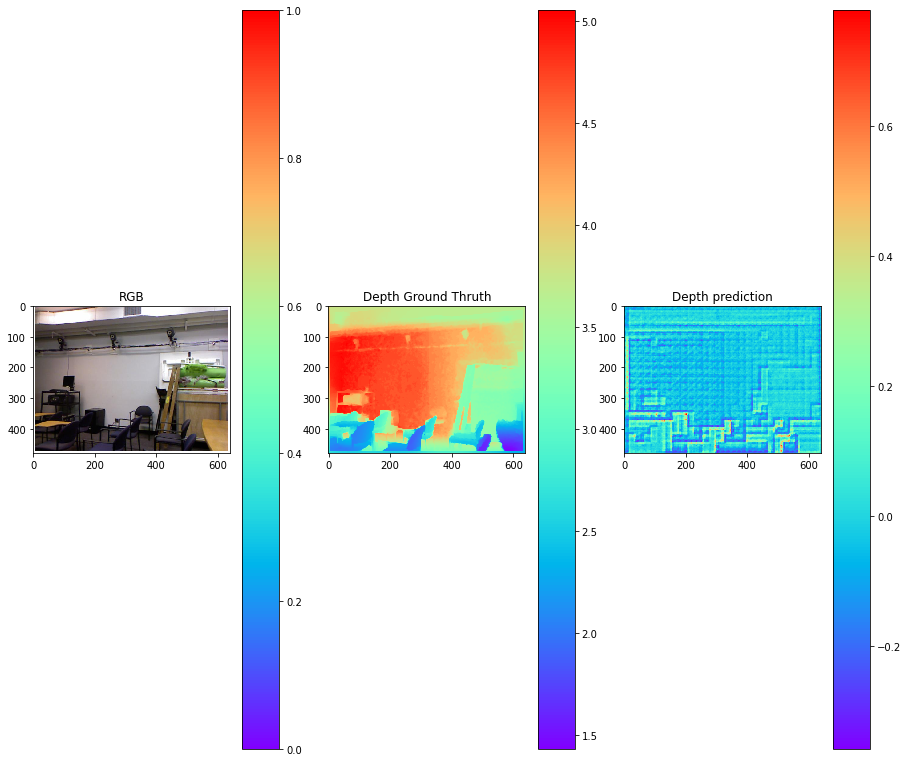

In [ ]:
""" Testing and visualising data """
model = D3()
model.load_state_dict(torch.load('./Model_D3_1_0_10.pt',map_location=torch.device('cuda')))
testloader = torch.utils.data.DataLoader(train_set, batch_size=2, shuffle=True, num_workers=n_workers)
mask = generate_mask(24, 24, 480, 640)   
img, depth = next(iter(testloader))
    
with torch.no_grad():
  model.eval()
  model.to(device)
            
  NN = []
  #concat x with spatial data
  for j in range(img.shape[0]):
    sp = NN_fill(img[j].numpy(), depth[j].numpy(), mask)
    NN.append(sp)
  
  NN = torch.tensor(NN)
  NN = NN.float()          
    
    
  img = (img.permute(0, 3, 1, 2))/255.
  img = img.to(device) 
  depth = depth.to(device)
  NN = NN.to(device)
  print(NN.shape)
  print(img.shape)
  print(depth.shape)
    
  fx = model(img, NN)
    
""" Plot """
plt.figure(figsize = (15, 15))
tets = img[0].permute(1, 2, 0)
tets = tets.cpu()
plt.subplot(1, 3, 1)
plt.imshow((tets), interpolation = 'none', cmap = 'rainbow')
plt.colorbar()
plt.title("RGB")
plt.subplot(1, 3, 2)
depth = depth.cpu()
plt.imshow(depth[0], interpolation = 'none', cmap = 'rainbow')
plt.colorbar()
plt.title("Depth Ground Thruth")
plt.subplot(1, 3, 3)
fx = fx.cpu()
plt.imshow(fx[0][0], interpolation = 'none', cmap = 'rainbow')
plt.colorbar()
plt.title("Depth prediction")

In [ ]:
depth[0].max()

tensor(0.2609)

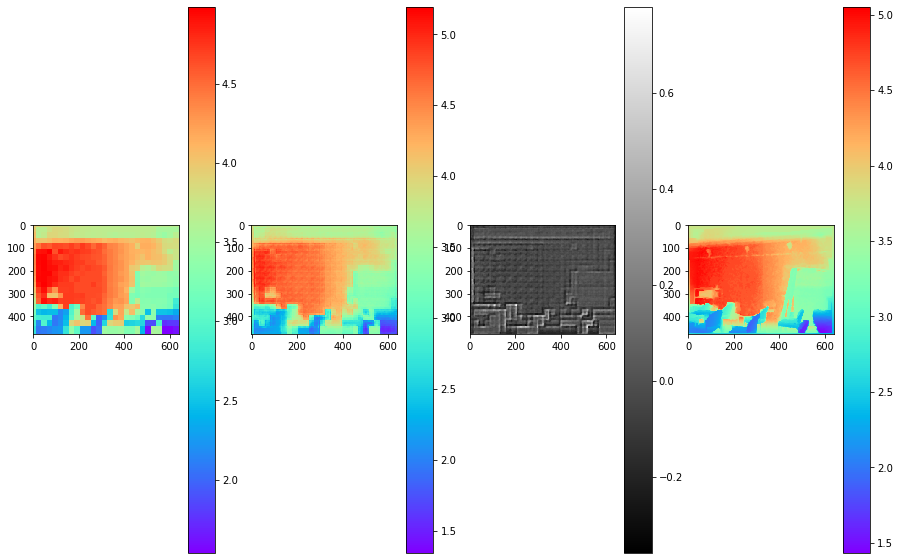

In [ ]:
plt.figure(1,figsize = (15, 15))
NN = NN.cpu()
NN = NN.permute(1,0,2,3)
fx = fx.permute(1,0,2,3)
test = NN[0]+fx[0]
plt.subplot(1, 4, 1)
plt.imshow(NN[0][0],interpolation = 'none',cmap = 'rainbow')
plt.colorbar()
plt.subplot(1, 4, 2)
plt.imshow(test[0],interpolation='none',cmap = 'rainbow')
plt.colorbar()
plt.subplot(1, 4, 3)
plt.imshow(fx[0][0],interpolation = 'none',cmap = 'gray')
plt.colorbar()
plt.subplot(1, 4, 4)
plt.imshow(depth[0],interpolation = 'none',cmap = 'rainbow')

plt.colorbar()

In [ ]:
img.max()

tensor(255, device='cuda:0', dtype=torch.uint8)

In [ ]:
exp = 24/(len(trainloader)*num_epochs)
exp

0.08

In [ ]:
num_epoch = 0
Train_step = 10
no_sparse = (5 * 533 * np.exp(-exp*Train_step))+533     # -0.24 because sparse sampling size/no. of training batches 24/100 in tis case
mask_sample = int(np.sqrt(1/(no_sparse/(480*640))))

In [ ]:
mask_sample

13